# Visual Interaction Network
From just a glance, humans can infer not only what and where objects are, but also what will happen to them over the upcoming seconds, minutes or even longer in some cases. For example, if you kick a football against a wall, your brain predicts what will happen when the ball hits the wall and their movement afterward. These predictions are guided by a sophisticated cognitive system for reasoning about objects and their mutual interactions.

Visual interaction network is a general-purpose model for learning the dynamics of a physical system from raw visual observations. The model consists of a perceptual front-end based on convolutional neural networks and a dynamics predictor based on interaction networks.  The following shows the comparison between the ground truth and the prediction from visual interaction network.

<img src="https://storage.googleapis.com/deepmind-live-cms/documents/ezgif.com-optimize%2520%25281%2529.gif" width="600"/>

## Overview
The **V**isual **I**nteraction **N**etwork (**VIN**) learns to produce future trajectories of objects in a physical system from only a few video frames.
- **Visual Encoder** takes a triplet of frames as input and outputs a state code. A state code is a list of vectors, one for each object in the scene. The encoder is applied in a sliding window fashion over a sequence of frames, producing a sequence of state codes.
- **Dynamics Predictor** takes a sequence of state codes (output from the visual encoder applied in a sliding-window manner from a sequence of frames) and predicts a candidate state code for the next frame. The dynamics predictor rolls the states forward in time by computing their interactions and dynamics, generating states of future timestep.
- **State Decoder** converts a state code to a output state, which has physical meanings and in our case, is a list of each objects's position and velocity vector.


<img src="https://i.imgur.com/isKXEwm.png" width="600">

In [1]:
!wget https://github.com/zswang666/Visual-Interaction-Network/raw/master/gravity_dataset.tar.gz
!tar zxf gravity_dataset.tar.gz

--2018-08-04 14:54:57--  https://github.com/zswang666/Visual-Interaction-Network/raw/master/gravity_dataset.tar.gz
Resolving github.com (github.com)... 192.30.253.113, 192.30.253.112
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/zswang666/Visual-Interaction-Network/master/gravity_dataset.tar.gz [following]
--2018-08-04 14:54:57--  https://raw.githubusercontent.com/zswang666/Visual-Interaction-Network/master/gravity_dataset.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132019 (1.1M) [application/octet-stream]
Saving to: ‘gravity_dataset.tar.gz’

gravity_dataset.tar 100%[===================>]   1.08M  --.-KB/s    in 0.1s    

2018-08-04 

In [60]:
""" Import Module """
import os
import time
import collections
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

%pylab inline
tf.reset_default_graph()

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['axes']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Parameters

In [0]:
""" Constant """
MODE = 'test' # train / test
PSEUDO = False # True for using psuedo inputs (no data); False for dataset

HEIGHT = 32 # image (frame) height
WIDTH = 32 # image width
N_CHANNELS = 4 # image channel
N_OBJECTS = 3 # number of objects in a scene
N_FRAMES = 6 # number of frames to be sent as inputs
FUTURE_N_STEPS = 8 # how far away from now we are predicting in training
IMG_DIR = './gravity_dataset/img/' # dataset: image directory
DATA_DIR = './gravity_dataset/data/' # dataset: data directory that stores labels
N_SETS = 10 # number of image sets (sequences)
SIM_FRAMES = 50 # number of saved frames per simulation

N_FILTERS = 128 # number of filters in Visual Encoder
STATE_DIMS = 64 # dimension of state codes
VE_STATE_DIMS = 64 # state dimensions of Visual Encoder
DP_STATE_DIMS = 64 # state dimensions of Dynamics Predictor
CORE_STATE_DIMS = 64 # state dimensions of cores
OUTPUT_DIMS = 4 # output state dimensions (position / velocity vectors)
TEMPORAL_OFFSETS = [1, 3, 4] # must be subset of (range(N_FRAMES - 2) + 1)

BATCH_SIZE = 4
LEARNING_RATE = 0.0005
ROLLOUT_NUM = 20
MAX_EPOCHS = 50

## Tensorflow Layer

In [0]:
""" Tensorflow Layer """
def _get_variable(name, shape, initializer=None):
    return tf.get_variable(name, shape, initializer=initializer)


def Linear(scope, inputs, num_outputs, initializer=None, bias_zero_init=True,
           activation_fn=tf.nn.relu, skip_connection=False):
    with tf.variable_scope(scope):
        # specify weights and biases
        N = inputs.get_shape()[-1].value
        weight = _get_variable('weights',
                               shape=[N, num_outputs],
                               initializer=initializer)
        if bias_zero_init:
            biases = _get_variable('biases', [num_outputs],
                                   tf.constant_initializer(0.0))
        else: # NOTE: non-zero initializer for bias
            biases = _get_variable('biases', [num_outputs], None)
        # perform fully connected layer
        outputs = tf.nn.bias_add(tf.matmul(inputs, weight), biases)
        # skip connection
        if skip_connection:
            outputs = outputs + inputs
        # perform activation
        if activation_fn is not None:
            outputs = activation_fn(outputs)

    return outputs


def Conv2d(scope, inputs, num_output_channels, kernel_size=[3, 3], stride=[1, 1], padding='SAME',
           initializer=None, activation_fn=tf.nn.relu, skip_connection=False):
    with tf.variable_scope(scope):
        # specify weights and biases
        B, H, W, C = inputs.get_shape().as_list()
        kernel_h, kernel_w = kernel_size
        if initializer is None: # NOTE: special initializer used for convolution
            d = 1.0 / np.sqrt(C * kernel_h * kernel_w)
            initializer = tf.random_uniform_initializer(minval=-d, maxval=d)
        kernel_shape = [kernel_h, kernel_w, C, num_output_channels]
        kernel = _get_variable('weights',
                               shape=kernel_shape,
                               initializer=initializer)
        biases = _get_variable('biases', [num_output_channels],
                               initializer=initializer)
        # perform 2D convolution
        stride_h, stride_w = stride
        outputs = tf.nn.conv2d(inputs, kernel, strides=[1, stride_h, stride_w, 1], padding=padding)
        outputs = tf.nn.bias_add(outputs, biases)
        # skip connection
        if skip_connection:
            outputs = outputs + inputs
        # perform activation
        if activation_fn is not None:
            outputs = activation_fn(outputs)

    return outputs


def MaxPool2d(scope, inputs, kernel_size=[2, 2], stride=[2, 2], padding='SAME'):
    with tf.variable_scope(scope):
        kernel_h, kernel_w = kernel_size
        stride_h, stride_w = stride
        outputs = tf.nn.max_pool(inputs,
                                 ksize=[1, kernel_h, kernel_w, 1],
                                 strides=[1, stride_h, stride_w, 1],
                                 padding=padding,
                                 name='max-pool2d')
    return outputs

## Dataloader
### Inputs:
- **frames**: a sequence of frames of shape (```HEIGHT x WIDTH x N_CHANNELS```) with length ```N_FRAMES```.
- **x_coor, y_coor**: a sequence of *x, y* coordinates of shape (```HEIGHT x WIDTH x 1```) with length ```N_FRAMES```.
- **discount_factor**: a factor to discount the  prediction loss in further future steps.

### Labels:
- **current_label**: object states of shape (```N_OBJECTS x OUTPUT_DIMS```) of the input sequence. Note that the length is ```N_FRAMES - 2``` because we are using triplet while applying sliding window over the input sequence.
- **future_label**: predicted object states of shape (```N_OBJECTS x OUTPUT_DIMS```) in the future ```FUTURE_N_STEPS```.


If you set ```PSEUDO = True```, you are using placeholder as input layer, which specifies the shape of each inputs and labels. Set to ```True``` for debugging tensor shape consistency.

In [0]:
""" Dataloader """
class GravityDataset(object):
    def __init__(self, mode):
        assert mode in ['train', 'test'], \
               'Arguments \'mode\' of GravityDataset must be \'train\'/\'test\''
        self._mode = mode
        self.x_coor = None
        self.y_coor = None
        self._load_data(mode)
        self.frames, self.current_label, self.future_label = self._create()

    def _load_data(self, split):
        if split == 'train':
            n_sets = N_SETS
        else:
            n_sets = 1
        # read all images in the data split
        images = np.zeros((n_sets, SIM_FRAMES, HEIGHT, WIDTH, N_CHANNELS), dtype=np.float32)
        for i in range(n_sets):
            for j in range(SIM_FRAMES):
                img_path = os.path.join(IMG_DIR, split, '{}_{}.png'.format(i, j))
                images[i, j] = mpimg.imread(img_path)[:, :, :N_CHANNELS]

        # real all labels in the data split
        labels = np.zeros((n_sets, SIM_FRAMES, N_OBJECTS * 5), dtype=np.float32)
        for i in range(n_sets):
            f_path = os.path.join(DATA_DIR, split, '{}.csv'.format(i))
            f = open(f_path, 'r')
            labels[i] = [line[:-1].split(',') for line in f.readlines()]
        labels = np.reshape(labels, (n_sets, SIM_FRAMES, N_OBJECTS, 5))

        # prepare input data and corresponding labels
        n_valid_seqs = SIM_FRAMES - N_FRAMES - FUTURE_N_STEPS + 1
        input_images = np.zeros((n_sets * n_valid_seqs, N_FRAMES, HEIGHT, WIDTH, N_CHANNELS), dtype=np.float32)
        current_labels = np.zeros((n_sets * n_valid_seqs, N_FRAMES - 2, N_OBJECTS, OUTPUT_DIMS), dtype=np.float32)
        future_labels = np.zeros((n_sets * n_valid_seqs, FUTURE_N_STEPS, N_OBJECTS, OUTPUT_DIMS), dtype=np.float32)
        for i in range(n_sets):
            for j in range(n_valid_seqs):
                input_images[i * n_valid_seqs + j] = images[i, j:(j + N_FRAMES)]
                tmp = labels[i, (j + N_FRAMES - 4):(j + N_FRAMES)]
                tmp = np.reshape(tmp, (N_FRAMES - 2, N_OBJECTS, 5))
                current_labels[i * n_valid_seqs + j] = tmp[:, :, 1:5]
                tmp = labels[i, (j + N_FRAMES):(j + N_FRAMES + FUTURE_N_STEPS)]
                tmp = np.reshape(tmp, (FUTURE_N_STEPS, N_OBJECTS, 5))
                future_labels[i * n_valid_seqs + j] = tmp[:, :, 1:5]

        # x, y coordinate
        x = np.linspace(0, 1, WIDTH)
        y = np.linspace(0, 1, HEIGHT)
        xx, yy = np.meshgrid(x, y)
        self.x_coor = np.stack([np.expand_dims(xx, -1)] * BATCH_SIZE * (N_FRAMES - 1), 0)
        self.y_coor = np.stack([np.expand_dims(yy, -1)] * BATCH_SIZE * (N_FRAMES - 1), 0)

        # output data
        self._input_images = tf.convert_to_tensor(input_images)
        self._current_labels = tf.convert_to_tensor(current_labels)
        self._future_labels = tf.convert_to_tensor(future_labels)
        self._dataset_size = input_images.shape[0]

    def _create(self):
        DataFormat = collections.namedtuple('Data', 'frames, current_label, future_label')

        dataset = tf.data.Dataset.from_tensor_slices((self._input_images,
                                                      self._current_labels,
                                                      self._future_labels))
        if self._mode == 'train': # do shuffle
            dataset = dataset.shuffle(buffer_size=self._dataset_size)
            batch_size = BATCH_SIZE
        else:
            batch_size = 1
        dataset = dataset.repeat()
        dataset = dataset.batch(BATCH_SIZE)
        iterator = dataset.make_one_shot_iterator()
        batch_image, batch_cur_label, batch_fut_label = iterator.get_next()

        return DataFormat(frames=batch_image,
                          current_label=batch_cur_label,
                          future_label=batch_fut_label)

    @property
    def size(self):
        return self._dataset_size


if not PSEUDO:
    dset = GravityDataset(MODE)
    frames, current_label, future_label = dset.frames, dset.current_label, dset.future_label
    frames_list = tf.unstack(frames, N_FRAMES, 1)
    current_label_list = tf.unstack(current_label, N_FRAMES - 2, 1)
    future_label_list = tf.unstack(future_label, FUTURE_N_STEPS, 1)
    discount_factor = tf.placeholder(tf.float32, [], name='discount_factor')
    x_coor = tf.placeholder(tf.float32, [None, HEIGHT, WIDTH, 1], name='x_coordinate')
    y_coor = tf.placeholder(tf.float32, [None, HEIGHT, WIDTH, 1], name='y_coordinate')
else:
    # consecutive frames
    frames = tf.placeholder(tf.float32, [None, N_FRAMES, HEIGHT, WIDTH, N_CHANNELS], name='frames')
    frames_list = tf.unstack(frames, N_FRAMES, 1)
    # ground truth of current states
    current_label = tf.placeholder(tf.float32, [None, N_FRAMES - 2, N_OBJECTS, OUTPUT_DIMS], name='current_label')
    current_label_list = tf.unstack(current_label, N_FRAMES - 2, 1)
    # ground truth of future states
    future_label = tf.placeholder(tf.float32, [None, FUTURE_N_STEPS, N_OBJECTS, OUTPUT_DIMS], name='future_label')
    future_label_list = tf.unstack(future_label, FUTURE_N_STEPS, 1)
    # discount factor
    discount_factor = tf.placeholder(tf.float32, [], name='discount_factor')
    # x, y coordinates
    x_coor = tf.placeholder(tf.float32, [None, HEIGHT, WIDTH, 1], name='x_coordinate')
    y_coor = tf.placeholder(tf.float32, [None, HEIGHT, WIDTH, 1], name='y_coordinate')

## Visual Encoder
The **V**isual **E**ncoder (**VE**) is a CNN that produces a state code from a sequence of 3 images. 

**A frame pair encoder (IPE)** is applied to both consecutive pairs of frames in a sequence of 3 frames. It first <font color='red'>concatenate a pair of frames with a constant *x, y* coordinate channels</font> and <font color='red'>perform convolution and max-pooling alternatingly until unit width and height</font>.  The inclusion of constant coordinate channels allows positions to be incorporated throughout much of the processing. Also note that weight sharing is applied to approximates a <font color='red'>temporal convolution over the input sequence</font>.

**A slot-wise MLP** is then applied to the pair code to <font color='red'>produce state code of shape $N_{object}\times L_{code}$</font>, where $N_{object}$ is the number of objects in the scene and $L_{code}$ is the length of each state code slot.

Finally, we further encode two pairwise state code to a triplet with a sequence of fully-connected layers. Weight sharing is also applied here to approximates temporal convolution. The visual encoder is trained by a reconstruction loss applied to the decoded output of the visual encoder in the beginning of the sequence.

<img src="https://i.imgur.com/C0DEgje.png" width="500">

In [0]:
""" Visual Encoder """
def IPE(fpairs_list, x, y):
    with tf.variable_scope('IPE'):
        ##############################################################################################
        ###                    Temporal convolution approximated using weight sharing              ###
        ##############################################################################################
        fpairs = tf.concat(fpairs_list, 0)
        inputs = tf.concat([fpairs, x, y], 3)

        h_0 = MaxPool2d('mp_0', Conv2d('h_0', inputs, N_FILTERS))
        h_1 = MaxPool2d('mp_1', Conv2d('h_1', h_0, N_FILTERS, skip_connection=True))
        h_2 = MaxPool2d('mp_2', Conv2d('h_2', h_1, N_FILTERS, skip_connection=True))
        h_3 = MaxPool2d('mp_3', Conv2d('h_3', h_2, N_FILTERS, skip_connection=True))
        h_4 = MaxPool2d('mp_4', Conv2d('h_4', h_3, N_FILTERS, skip_connection=True))

        # separate along time axis
        pairs = tf.reshape(h_4, [-1, N_FILTERS])
        p_list = []
        for i in range(N_FRAMES - 1):
            p_list.append(tf.slice(pairs, [BATCH_SIZE * i, 0], [BATCH_SIZE, -1]))
        ##############################################################################################
        ###                                  End of your code                                      ###
        ##############################################################################################

    return p_list


def VE(f_list, x, y):
    with tf.variable_scope('VE'):
        ### Construct Temporal Pairs ###
        # concat two consecutive frames as a pair and encode
        fpairs_list = []
        for i in range(len(f_list) - 1):
            fpairs_list.append(tf.concat([f_list[i], f_list[i+1]], 3))
        pairs_list = IPE(fpairs_list, x, y)
        pairs = tf.concat(pairs_list, 0)

        # temporal convolution approximated by fully-connected layer with weight sharing
        h_0 = Linear('h_0', pairs, N_OBJECTS * STATE_DIMS, activation_fn=None, initializer=tf.truncated_normal_initializer(stddev=0.1))
        enpairs_list = []
        for i in range(N_FRAMES - 1):
            enpair = tf.slice(h_0, [BATCH_SIZE * i, 0], [BATCH_SIZE, -1])
            enpair = tf.reshape(enpair, [-1, N_OBJECTS, STATE_DIMS])
            enpairs_list.append(enpair)

        ### Construct Temporal Triplets ###
        # concat two consecutive pairs as a triplet and encode
        triplets_list = []
        for i in range(N_FRAMES - 2):
            triplets_list.append(tf.concat([enpairs_list[i], enpairs_list[i+1]], 2))
        triplets = tf.concat(triplets_list, 0)
        triplets = tf.reshape(triplets, [-1, STATE_DIMS * 2])

        h_1 = Linear('h_1', triplets, VE_STATE_DIMS, initializer=tf.truncated_normal_initializer(stddev=0.1))
        h_2 = Linear('h_2', h_1, VE_STATE_DIMS, skip_connection=True, initializer=tf.truncated_normal_initializer(stddev=0.1))
        h_3 = Linear('h_3', h_2, VE_STATE_DIMS, skip_connection=True, initializer=tf.truncated_normal_initializer(stddev=0.1))

        # separate along time axis
        encoded_triplets = tf.reshape(h_3, [-1, N_OBJECTS, STATE_DIMS])
        s_list = []
        for i in range(N_FRAMES - 2):
            s_list.append(tf.slice(encoded_triplets, [BATCH_SIZE * i, 0, 0], [BATCH_SIZE, -1, -1]))

    return s_list


sliding_window_list = VE(frames_list, x_coor, y_coor)

## Dynamics Predictor and Rollout
The **D**ynamic **P**redictor (**DP**) is a variant of an **I**nteraction **N**etwork (**IN**), a state-to-state physical predictor model.  For each time offset *t*, given an input state code sequence (output from VE), a core of DP is an IN which takes objects dynamics and their interaction into consideration to predict future state code. The main difference between DP and a vanilla IN is aggregation over multiple temporal offsets. The temporal offset aggregation enhances its power by allowing it to accommodate both fast and slow movements by different objects within a sequence of frames.

<img src="https://i.imgur.com/3qCP4lf.png" width="400">

**Interaction Network**
<font color="magenta">GGGGGGGGGGGGGGGGGGGGGGGGGG</font>

<img src="https://i.imgur.com/159L98K.png" width="800">

**Self-Dynamics Module** models the dynamics of an objects itself. It is composed of <font color="red">2 fully-connected layers that convert state code for each object in each time step</font>. The output dimensions of the 2 fully-connected layers are both ```CORE_STATE_DIMS```.

**Relation Module** models the relation of a pair of objects. It <font color="red">considers the potential relations between all object pairs</font>. For a pair in all *permutations*, <font color="red">state codes of the two objects are concatenated to form an input pair</font>, which will be subsequently sent into relation network. The relation network consists of 3 fully-connected layer with output dimension as ```CORE_STATE_DIMS```. Finally, we <font color="red">accumulate all the effects over a specific object</font>, outputing a state code of shape (```N_OBJECTS x CORE_STATE_DIMS```).

<img src="https://i.imgur.com/1NQQR2q.png" width="800">

The results of self-dynamics module and relation module are summed and post-processed by the affector. The affector output is further concatenated to the input state sequence and sent to the output module to produce the predicted slot.

**Rollout** is performed by recursively sending a rolling state sequence to DP to predict state code in future steps. The rolling process of the state sequence is to <font color="red">abandon the oldest state and concatenate the upcoming predicted future state to the state sequence</font>. This can be implemented using function ```tf.scan()``` ([TensorFlow Scan Examples](https://rdipietro.github.io/tensorflow-scan-examples/)).

<img src="https://i.imgur.com/OS04r29.png" width="350">


In [0]:
""" Dynamics Predictor and Rollout """
def core(state, index):
    with tf.variable_scope('core_{}'.format(index)):
        ##############################################################################################
        ###                           Implement self-dynamics module                               ###
        ##############################################################################################
        ### Self-Dynamics Module ###
        with tf.variable_scope('self_dynamics'):
            SD_inputs = tf.reshape(state, [-1, STATE_DIMS])
            h_1 = Linear('h_1', SD_inputs, CORE_STATE_DIMS, bias_zero_init=False)
            h_2 = Linear('h_2', h_1, CORE_STATE_DIMS, skip_connection=True, bias_zero_init=False, activation_fn=None)
            SD_outputs = tf.reshape(h_2, [-1, N_OBJECTS, CORE_STATE_DIMS])

        ##############################################################################################
        ###                                  End of your code                                      ###        
        ##############################################################################################
        
        ##############################################################################################
        ###                              Implement relation module                                 ###
        ##############################################################################################
        ### Relation Module ###
        n_relations = int(N_OBJECTS * (N_OBJECTS - 1))
        with tf.variable_scope('relation_module'):
            # collect object pairs as inputs
            objects_list = tf.unstack(state, N_OBJECTS, 1)
            RM_inputs = []
            for i in range(n_relations):
                obj_1 = objects_list[int(i / (N_OBJECTS - 1))]
                obj_2 = objects_list[int(i % (N_OBJECTS - 1))]
                RM_inputs.append(tf.concat([obj_1, obj_2], 1))
            RM_inputs = tf.concat(RM_inputs, 0)

            # relation network
            h_1 = Linear('h_1', RM_inputs, CORE_STATE_DIMS, bias_zero_init=False)
            h_2 = Linear('h_2', h_1, CORE_STATE_DIMS, skip_connection=True, bias_zero_init=False)
            h_3 = Linear('h_3', h_2, CORE_STATE_DIMS, skip_connection=True, bias_zero_init=False, activation_fn=None)
            RM_outputs = tf.split(h_3, n_relations, 0)

            # accumulate all pairwise effects in an object
            acc_relations = np.zeros(N_OBJECTS, dtype=object)
            for i in range(N_OBJECTS):
                for j in range(N_OBJECTS - 1):
                    acc_relations[i] += RM_outputs[i * (N_OBJECTS - 1) + j]
            acc_relations = tf.stack(list(acc_relations), 1)
        ##############################################################################################
        ###                                  End of your code                                      ###
        ##############################################################################################
        
        ### Fuse Self-Dynamics and Relations ###
        fused_obj_states = SD_outputs + acc_relations

        ### Affector ###
        with tf.variable_scope('affector'):
            AFF_inputs = tf.reshape(fused_obj_states, [-1, CORE_STATE_DIMS])
            h_1 = Linear('h_1', AFF_inputs, CORE_STATE_DIMS, skip_connection=True, bias_zero_init=False)
            h_2 = Linear('h_2', h_1, CORE_STATE_DIMS, skip_connection=True, bias_zero_init=False)
            h_3 = Linear('h_3', h_2, CORE_STATE_DIMS, skip_connection=True, bias_zero_init=False, activation_fn=None)
            AFF_outputs = tf.reshape(h_3, [-1, N_OBJECTS, CORE_STATE_DIMS])

        ### Output Module ###
        with tf.variable_scope('output'):
            OUT_inputs = tf.reshape(tf.concat([state, AFF_outputs], 2), [-1, STATE_DIMS + CORE_STATE_DIMS])
            h_1 = Linear('h_1', OUT_inputs, CORE_STATE_DIMS, bias_zero_init=False)
            h_2 = Linear('h_2', h_1, CORE_STATE_DIMS, bias_zero_init=False, activation_fn=None)
            OUT_outputs = tf.reshape(h_2, [-1, N_OBJECTS, STATE_DIMS])

    return OUT_outputs


def DP(states_list):
    with tf.variable_scope('DP'):
        ### Pairwise Relation and Self-Dynamics of objects ###
        with tf.variable_scope('core'):
            relations_list = []
            for i in TEMPORAL_OFFSETS:
                relations_list.append(core(states_list[i - 1], N_FRAMES - 1 + i))
            relations = tf.concat(relations_list, 2)
            relations = tf.reshape(relations, [-1, STATE_DIMS * len(TEMPORAL_OFFSETS)])

        ### Aggregator ###
        with tf.variable_scope('aggregator'):
            h_1 = Linear('h_1', relations, DP_STATE_DIMS, bias_zero_init=False)
            h_2 = Linear('h_2', h_1, STATE_DIMS, activation_fn=None, bias_zero_init=False)
            h_2 = tf.reshape(h_2, [-1, N_OBJECTS, STATE_DIMS])

    return h_2


##############################################################################################
###    Given a short segment of sequence, please perform rollout using dynamic predictor   ###
##############################################################################################
def rollout_DP(prev_out, cur_in):
    states_list = tf.unstack(prev_out, N_FRAMES - 2, 0)
    state_pred = DP(states_list)
    out = tf.stack(states_list[1:] + [state_pred], 0)
    return out

elems = tf.identity(tf.Variable(tf.zeros([ROLLOUT_NUM], dtype=tf.float32)))
rollout_init = tf.stack(sliding_window_list, 0)
rollout = tf.scan(rollout_DP, elems, initializer=rollout_init)
##############################################################################################
###                                  End of your code                                      ###
##############################################################################################
state_pred = tf.unstack(rollout, N_FRAMES - 2, 1)[-1] # obtain the last step in the rollout
state_pred = tf.stack(tf.unstack(state_pred, BATCH_SIZE, 1), 0) # change axis of rollout step and batch
state_pred = tf.reshape(state_pred, [-1, N_OBJECTS, STATE_DIMS])

## State Decoder
The state decoder is simply <font color='blue'>a linear layer with input size $L_{code}$ and output size 4</font> (for position / velocity vector). This linear layer is applied independently to each slot of the state code.The state decoder is applied to both encoded state codes in current time steps (for reconstruction loss) and the predicted future states codes (for prediction loss).

In [0]:
""" State Decoder """
def SD(states):
    SD_inputs = tf.reshape(states, [-1, STATE_DIMS])
    h_1 = Linear('h_1', SD_inputs, OUTPUT_DIMS, initializer=tf.truncated_normal_initializer(stddev=0.1), activation_fn=None)
    SD_outputs = tf.reshape(h_1, [-1, N_OBJECTS, OUTPUT_DIMS])

    return SD_outputs


# decode all states
all_states = tf.concat(sliding_window_list + [state_pred], 0)
output_states = SD(all_states)

# encoded-decoded current states
current_states_pred = []
for i in range(N_FRAMES - 2):
    s_pred = tf.slice(output_states, [BATCH_SIZE * i, 0, 0], [BATCH_SIZE, -1, -1])
    current_states_pred.append(s_pred)

# predicted future states
future_states_pred = tf.slice(output_states, [BATCH_SIZE * (N_FRAMES - 2), 0, 0], [-1, -1, -1])
future_states_pred = tf.reshape(future_states_pred, [BATCH_SIZE, ROLLOUT_NUM, N_OBJECTS, OUTPUT_DIMS])
nstep_future_states_pred = tf.unstack(future_states_pred, ROLLOUT_NUM, 1)[:FUTURE_N_STEPS]

## Loss and Trainer

In [0]:
""" Loss and Trainer """
### Losses ###
# visual encoder loss
ve_loss = tf.reduce_mean(tf.square(current_label_list[0] - current_states_pred[0]))
for i in range(1, N_FRAMES - 2):
    ve_loss += tf.reduce_mean(tf.square(current_label_list[i] - current_states_pred[i]))
ve_loss = ve_loss / (N_FRAMES - 2)

# dynamics predictor loss, posed on predicted future n-step output states
dp_loss = discount_factor * tf.reduce_mean(tf.square(future_label_list[0] - nstep_future_states_pred[0]))
for i in range(1, FUTURE_N_STEPS):
    dp_loss += ((discount_factor ** (i + 1)) * tf.reduce_mean(tf.square(future_label_list[i] - nstep_future_states_pred[i])))
dp_loss = dp_loss / FUTURE_N_STEPS

loss = ve_loss + dp_loss

### Trainer ###
optimizer = tf.train.AdamOptimizer(LEARNING_RATE)
trainer = optimizer.minimize(loss)

### Session and Initializer ###
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
tf_config.allow_soft_placement = True
tf_config.log_device_placement = False
sess = tf.Session(config=tf_config)
sess.run(tf.global_variables_initializer())

## Training and Testing
<img src="https://i.imgur.com/Pux22wI.png" width="400">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
<img src="https://i.imgur.com/iprRS3T.gif" width="200">
<img src="https://i.imgur.com/7DaRQeq.gif" width="200">

INFO:tensorflow:Restoring parameters from ./model-ep00030.ckpt


KeyError: ignored

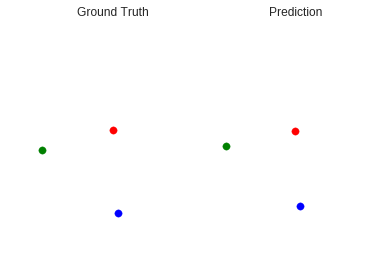

In [68]:
""" Training / Testing """
assert PSEUDO == False, 'Please turn off \'PSEUDO\' for training or testing'
saver = tf.train.Saver(max_to_keep=5)
if MODE == 'train':
    discount_factor_value = 1
    for ep in range(MAX_EPOCHS):
        tic = time.time()
        loss_list = []
        ve_loss_list = []
        dp_loss_list = []
        for it in range(int(dset.size / BATCH_SIZE)):
            feed_dict = {discount_factor: discount_factor_value,
                         x_coor: dset.x_coor,
                         y_coor: dset.y_coor}
            fetch = [loss, ve_loss, dp_loss, trainer]
            loss_, ve_loss_, dp_loss_, _ = sess.run(fetch, feed_dict)
            loss_list.append(loss_)
            ve_loss_list.append(ve_loss_)
            dp_loss_list.append(dp_loss_)
        toc = time.time()
        avg_loss = np.mean(loss_list)
        avg_ve_loss = np.mean(ve_loss_list)
        avg_dp_loss = np.mean(dp_loss_list)
        print('Epoch [{}/{}]: loss = {:.2f}, ve_loss = {:.2f}, dp_loss = {:.2f}, epoch_time = {:.2f}'.\
              format(ep, MAX_EPOCHS, avg_loss, avg_ve_loss, avg_dp_loss, toc - tic))
        
        if ((ep % 10) == 0 and ep != 0) or ep == (MAX_EPOCHS - 1):
            ckpt_path = './model-ep{:05}.ckpt'.format(ep)
            print('Save checkpoint to {}'.format(ckpt_path))
            saver.save(sess, ckpt_path)
        
else:
    # load model
    saver.restore(sess, './model-ep00030.ckpt')

    # prediction
    feed_dict = {x_coor: dset.x_coor,
                 y_coor: dset.y_coor}
    fetch = [future_states_pred, dset._current_labels, dset._future_labels]
    future_states_pred_, current_labels_, future_labels_ = sess.run(fetch, feed_dict)
    xy_origin = future_labels_[:(SIM_FRAMES - (N_FRAMES + FUTURE_N_STEPS) + 1 - (N_FRAMES - 2) + 1), 0, :, 0:2]
    vel = future_states_pred_[0, :, :, 2:4]
    xy_estimate = np.zeros((ROLLOUT_NUM, N_OBJECTS, 2), dtype=float)
    xy_estimate[0] = current_labels_[3][3][:, :2] + vel[0] * 0.01
    for i in range(1, future_states_pred_.shape[0]):
        xy_estimate[i] = xy_estimate[i - 1] + vel[i] * 0.01

    # visualize
    amp_factor = 9
    fig, axes = plt.subplots(1, 2)
    color = ['r', 'b', 'g', 'y', 'm', 'c']
    for ax in axes:
        ax.set_xlim(-100 * amp_factor, 100 * amp_factor)
        ax.set_ylim(-100 * amp_factor, 100 * amp_factor)
        ax.axis('off')
    axes[0].set_title('Ground Truth')
    axes[1].set_title('Prediction')
    scat_ori = []
    scat_est = []
    for j in range(N_OBJECTS):
        scat_ori.append(axes[0].scatter(xy_origin[0, j, 1] * amp_factor, 
                                        xy_origin[0, j, 0] * amp_factor, 
                                        c=color[j % len(color)], s=(6 * amp_factor)))
        scat_est.append(axes[1].scatter(xy_estimate[0, j, 1] * amp_factor, 
                                        xy_estimate[0, j, 0] * amp_factor, 
                                        c=color[j % len(color)], s=(6 * amp_factor)))
    def update(i):
        for j in range(N_OBJECTS):
            scat_ori[j].set_offsets([xy_origin[i, j, 1] * amp_factor, 
                                     xy_origin[i, j, 0] * amp_factor])
            scat_est[j].set_offsets([xy_estimate[i, j, 1] * amp_factor, 
                                     xy_estimate[i, j, 0] * amp_factor])
    anim_frames = min(xy_origin.shape[0], xy_estimate.shape[0])
    anim = FuncAnimation(fig, update, frames=anim_frames, interval=500, repeat=True)
    #HTML(anim.to_html5_video())
    plt.show()

## References
- Battaglia P, Pascanu R, Lai M, Rezende DJ. [Interaction networks for learning about objects, relations and physics](https://arxiv.org/abs/1612.00222). NIPS 2016
- Santoro A, Raposo D, Barrett DG, Malinowski M, Pascanu R, Battaglia P, Lillicrap T. [A simple neural network module for relational reasoning](https://arxiv.org/abs/1706.01427). NIPS 2017
- Watters N, Tacchetti A, Weber T, Pascanu R, Battaglia P, Zoran D. [Visual interaction networks](https://arxiv.org/abs/1706.01433). arXiv 2017
- [A neural approach to relational reasoning](https://deepmind.com/blog/neural-approach-relational-reasoning/)
- [visual-interaction-networks_tensorflow](https://github.com/jaesik817/visual-interaction-networks_tensorflow)


## Solutions
- <font size="4">**Temporal convolution in IPE**:</font><font color="white">
    
```
fpairs = tf.concat(fpairs_list, 0)
inputs = tf.concat([fpairs, x, y], 3)

h_0 = MaxPool2d('mp_0', Conv2d('h_0', inputs, N_FILTERS))
h_1 = MaxPool2d('mp_1', Conv2d('h_1', h_0, N_FILTERS, skip_connection=True))
h_2 = MaxPool2d('mp_2', Conv2d('h_2', h_1, N_FILTERS, skip_connection=True))
h_3 = MaxPool2d('mp_3', Conv2d('h_3', h_2, N_FILTERS, skip_connection=True))
h_4 = MaxPool2d('mp_4', Conv2d('h_4', h_3, N_FILTERS, skip_connection=True))

# separate along time axis
pairs = tf.reshape(h_4, [-1, N_FILTERS])
p_list = []
for i in range(N_FRAMES - 1):
    p_list.append(tf.slice(pairs, [BATCH_SIZE * i, 0], [BATCH_SIZE, -1]))
```
</font>
- <font size="4">**Self-dynamics module:**</font><font color="white">

```
### Self-Dynamics Module ###
with tf.variable_scope('self_dynamics'):
    SD_inputs = tf.reshape(state, [-1, STATE_DIMS])
    h_1 = Linear('h_1', SD_inputs, CORE_STATE_DIMS, bias_zero_init=False)
    h_2 = Linear('h_2', h_1, CORE_STATE_DIMS, skip_connection=True, bias_zero_init=False, activation_fn=None)
```
</font>
- <font size="4">**Relation module:**</font><font color="white">

```
n_relations = int(N_OBJECTS * (N_OBJECTS - 1))
with tf.variable_scope('relation_module'):
    # collect object pairs as inputs
    objects_list = tf.unstack(state, N_OBJECTS, 1)
    RM_inputs = []
    for i in range(n_relations):
        obj_1 = objects_list[int(i / (N_OBJECTS - 1))]
        obj_2 = objects_list[int(i % (N_OBJECTS - 1))]
        RM_inputs.append(tf.concat([obj_1, obj_2], 1))
    RM_inputs = tf.concat(RM_inputs, 0)

    # relation network
    h_1 = Linear('h_1', RM_inputs, CORE_STATE_DIMS, bias_zero_init=False)
    h_2 = Linear('h_2', h_1, CORE_STATE_DIMS, skip_connection=True, bias_zero_init=False)
    h_3 = Linear('h_3', h_2, CORE_STATE_DIMS, skip_connection=True, bias_zero_init=False, activation_fn=None)
    RM_outputs = tf.split(h_3, n_relations, 0)

    # accumulate all pairwise effects in an object
    acc_relations = np.zeros(N_OBJECTS, dtype=object)
    for i in range(N_OBJECTS):
        for j in range(N_OBJECTS - 1):
            acc_relations[i] += RM_outputs[i * (N_OBJECTS - 1) + j]
    acc_relations = tf.stack(list(acc_relations), 1)
```
</font>
- <font size="4">**Rollout:**</font><font color="white">

```
def rollout_DP(prev_out, cur_in):
    states_list = tf.unstack(prev_out, N_FRAMES - 2, 0)
    state_pred = DP(states_list)
    out = tf.stack(states_list[1:] + [state_pred], 0)
    return out

elems = tf.identity(tf.Variable(tf.zeros([ROLLOUT_NUM], dtype=tf.float32)))
rollout_init = tf.stack(sliding_window_list, 0)
rollout = tf.scan(rollout_DP, elems, initializer=rollout_init)
```
</font>

